In [33]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1. Prepare

In [2]:
%load_ext autoreload

%autoreload 2

In [1]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import os
import sys
from skimage.color import rgb2gray
from skimage.transform import rescale, resize


#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Read Dataframes:

In [4]:
df = pd.read_pickle(DATA_BASE_PATH+"/new_df")
df.head(3)

image_path                    mask_path  \
0  ../data/00_train_all/images/  ../data/00_train_all/masks/   
1  ../data/00_train_all/images/  ../data/00_train_all/masks/   
2  ../data/00_train_all/images/  ../data/00_train_all/masks/   

                      mask_cirlce_path          name dataset  \
0  ../data/00_train_all/masks_autogen/  img_1000.png    None   
1  ../data/00_train_all/masks_autogen/  img_1001.png    None   
2  ../data/00_train_all/masks_autogen/  img_1002.png    None   

                                            mask_rle  \
0  698 29 818 9 2234 31 2353 11 3770 31 3887 15 5...   
1  438414 2 439945 12 441479 16 443014 18 444549 ...   
2  34961 2 36493 11 38028 16 39562 20 41097 21 42...   

                                     mask_circle_rle  \
0  334006 81 338587 135 343177 171 347770 201 352...   
1  1974403 81 1978984 135 1983574 171 1988167 201...   
2  906988 81 911569 135 916159 171 920752 201 925...   

                                               roots  \
0  [[756.8607304952216, 225.09973947065592], [710...   
1            [[739.719006081668, 581.6527981588033]]   
2  [[574.2998575152042, 389.7725495972382], [1286...   

                                             splines  
0  [[[691.7071068635969, 651.3522006904487], [726...  
1  [[[677.6301761946132, 954.4418894361334], [690...  
2  [[[842.6653470026065, 435.1941376294591], [898...

# Split Data

In [5]:
import math
df_shuffeled = df.sample(frac=1)
train_size = 0.7
val_size = 0.2
test_size = 0.1
samples = len(df_shuffeled)

train_ind = math.floor(samples*train_size)
val_ind = train_ind + math.floor(samples*val_size)
test_ind = train_ind + val_ind + math.floor(samples*test_size)

train_df = df_shuffeled[0:train_ind].reset_index(drop=True)
val_df = df_shuffeled[train_ind:val_ind+1].reset_index(drop=True)
test_df = df_shuffeled[val_ind:-1].reset_index(drop=True)

print("Number of training Samples:", len(train_df))
print("Number of validation Samples:", len(val_df))
print("Number of test Samples:", len(test_df))

Number of training Samples: 354
Number of validation Samples: 102
Number of test Samples: 51


### If Available, load existing Model:

In [7]:
from imports.models.losses import bce_dice_loss, dice_coeff
from keras.models import load_model, model_from_json

import keras.losses
keras.losses.custom_loss = bce_dice_loss

model = load_model('../saved_models/unet/unet1024_120epochs_roots.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coeff':dice_coeff})

# 3 Training:

Weighted Loss Map Test:

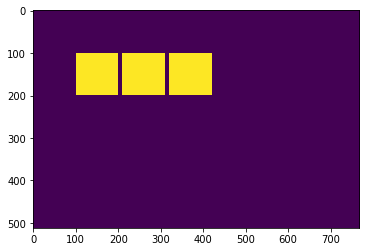

In [8]:
from skimage.draw import rectangle
w = np.zeros((SHAPE), dtype=np.uint8)
start = (1, 1)
extent = (3, 3)
rr, cc = rectangle((100,100), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
rr, cc = rectangle((100,210), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
rr, cc = rectangle((100,320), extent=(100,100), shape=w.shape)
w[rr, cc] = 1
test = w
imshow(w)

9.596327636025421

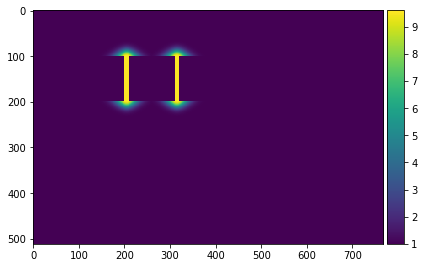

In [9]:
# https://stackoverflow.com/questions/50255438/pixel-wise-loss-weight-for-image-segmentation-in-keras

%matplotlib inline
import numpy as np
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt

def unet_weight_map(y, wc=None, w0 = 10, sigma = 20):

    """
    Generate weight maps as specified in the U-Net paper
    for boolean mask.

    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    https://arxiv.org/pdf/1505.04597.pdf

    Parameters
    ----------
    mask: Numpy array
        2D array of shape (image_height, image_width) representing binary mask
        of objects.
    wc: dict
        Dictionary of weight classes.
    w0: int
        Border weight parameter.
    sigma: int
        Border width parameter.

    Returns
    -------
    Numpy array
        Training weights. A 2D array of shape (image_height, image_width).
    """
    y = y.astype(bool)
    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(np.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:,:,i] = distance_transform_edt(labels != label_id)

        distances = np.sort(distances, axis=2)
        d1 = distances[:,:,0]
        d2 = distances[:,:,1]
        w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

        if wc:
            class_weights = np.zeros_like(y)
            for k, v in wc.items():
                class_weights[y == k] = v
            w = w + class_weights
    else:
        w = np.zeros_like(y)

    return w

wc = {
    0: 1, # background
    1: 5  # objects
}

w2 = unet_weight_map(test, wc)

imshow(w2)
w2.max()

### 3.1 Load UNet Model:

In [6]:
model = get_unet(input_shape=(SHAPE[0],SHAPE[1],3))

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 768, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 768, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 768, 8)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
val_df

image_path                    mask_path  \
0    ../data/00_train_all/images/  ../data/00_train_all/masks/   
1    ../data/00_train_all/images/  ../data/00_train_all/masks/   
2    ../data/00_train_all/images/  ../data/00_train_all/masks/   
3    ../data/00_train_all/images/  ../data/00_train_all/masks/   
4    ../data/00_train_all/images/  ../data/00_train_all/masks/   
5    ../data/00_train_all/images/  ../data/00_train_all/masks/   
6    ../data/00_train_all/images/  ../data/00_train_all/masks/   
7    ../data/00_train_all/images/  ../data/00_train_all/masks/   
8    ../data/00_train_all/images/  ../data/00_train_all/masks/   
9    ../data/00_train_all/images/  ../data/00_train_all/masks/   
10   ../data/00_train_all/images/  ../data/00_train_all/masks/   
11   ../data/00_train_all/images/  ../data/00_train_all/masks/   
12   ../data/00_train_all/images/  ../data/00_train_all/masks/   
13   ../data/00_train_all/images/  ../data/00_train_all/masks/   
14   ../data/00_train_all/images/  ../data/00_train_all/masks/   
15   ../data/00_train_all/images/  ../data/00_train_all/masks/   
16   ../data/00_train_all/images/  ../data/00_train_all/masks/   
17   ../data/00_train_all/images/  ../data/00_train_all/masks/   
18   ../data/00_train_all/images/  ../data/00_train_all/masks/   
19   ../data/00_train_all/images/  ../data/00_train_all/masks/   
20   ../data/00_train_all/images/  ../data/00_train_all/masks/   
21   ../data/00_train_all/images/  ../data/00_train_all/masks/   
22   ../data/00_train_all/images/  ../data/00_train_all/masks/   
23   ../data/00_train_all/images/  ../data/00_train_all/masks/   
24   ../data/00_train_all/images/  ../data/00_train_all/masks/   
25   ../data/00_train_all/images/  ../data/00_train_all/masks/   
26   ../data/00_train_all/images/  ../data/00_train_all/masks/   
27   ../data/00_train_all/images/  ../data/00_train_all/masks/   
28   ../data/00_train_all/images/  ../data/00_train_all/masks/   
29   ../data/00_train_all/images/  ../data/00_train_all/masks/   
..                            ...                          ...   
72   ../data/00_train_all/images/  ../data/00_train_all/masks/   
73   ../data/00_train_all/images/  ../data/00_train_all/masks/   
74   ../data/00_train_all/images/  ../data/00_train_all/masks/   
75   ../data/00_train_all/images/  ../data/00_train_all/masks/   
76   ../data/00_train_all/images/  ../data/00_train_all/masks/   
77   ../data/00_train_all/images/  ../data/00_train_all/masks/   
78   ../data/00_train_all/images/  ../data/00_train_all/masks/   
79   ../data/00_train_all/images/  ../data/00_train_all/masks/   
80   ../data/00_train_all/images/  ../data/00_train_all/masks/   
81   ../data/00_train_all/images/  ../data/00_train_all/masks/   
82   ../data/00_train_all/images/  ../data/00_train_all/masks/   
83   ../data/00_train_all/images/  ../data/00_train_all/masks/   
84   ../data/00_train_all/images/  ../data/00_train_all/masks/   
85   ../data/00_train_all/images/  ../data/00_train_all/masks/   
86   ../data/00_train_all/images/  ../data/00_train_all/masks/   
87   ../data/00_train_all/images/  ../data/00_train_all/masks/   
88   ../data/00_train_all/images/  ../data/00_train_all/masks/   
89   ../data/00_train_all/images/  ../data/00_train_all/masks/   
90   ../data/00_train_all/images/  ../data/00_train_all/masks/   
91   ../data/00_train_all/images/  ../data/00_train_all/masks/   
92   ../data/00_train_all/images/  ../data/00_train_all/masks/   
93   ../data/00_train_all/images/  ../data/00_train_all/masks/   
94   ../data/00_train_all/images/  ../data/00_train_all/masks/   
95   ../data/00_train_all/images/  ../data/00_train_all/masks/   
96   ../data/00_train_all/images/  ../data/00_train_all/masks/   
97   ../data/00_train_all/images/  ../data/00_train_all/masks/   
98   ../data/00_train_all/images/  ../data/00_train_all/masks/   
99   ../data/00_train_all/images/  ../data/00_train_all/masks/   
100  ../data/00_train_all/images/  ../data/00_train_all/masks/ 

In [28]:
from keras.preprocessing.image import ImageDataGenerator

def get_generators(batch_size=4):
    seed = np.random.choice(range(9999))

    dg_args = dict(featurewise_center = False, 
                      samplewise_center = False,
                      rotation_range = 5, 
                      width_shift_range = 0.01, 
                      height_shift_range = 0.01, 
                      shear_range = 0.01,
                      zoom_range = [0.9, 1.1],  
                      horizontal_flip = True, 
                      vertical_flip = True,
                      fill_mode = 'nearest',
                      data_format = 'channels_last',
                      rescale = 1.0/255.0)

    datagen=ImageDataGenerator(**dg_args)

    tg_args = dict(x_col="name", 
                   class_mode=None, 
                   target_size=SHAPE, 
                   batch_size=batch_size,
                   seed=seed)

    print('Training generator:')
    train_image_generator=datagen.flow_from_dataframe(dataframe=train_df, directory="../data/00_train_all/images",color_mode='rgb', **tg_args)
    train_mask_generator=datagen.flow_from_dataframe(dataframe=train_df, directory="../data/00_train_all/masks",color_mode='grayscale', **tg_args)
    train_gen = zip(train_image_generator,train_mask_generator)

    print('Validation generator:')
    val_image_generator=datagen.flow_from_dataframe(dataframe=val_df, directory="../data/00_train_all/images",color_mode='rgb', **tg_args)
    val_mask_generator=datagen.flow_from_dataframe(dataframe=val_df, directory="../data/00_train_all/masks",color_mode='grayscale', **tg_args)
    val_gen = zip(val_image_generator,val_mask_generator)
    
    return train_gen, val_gen

train_gen, val_gen = get_generators()

Training generator:
Found 354 images.
Found 354 images.
Validation generator:
Found 102 images.
Found 102 images.


In [29]:
train_gen, val_gen = get_generators(20)

Training generator:
Found 354 images.
Found 354 images.
Validation generator:
Found 102 images.
Found 102 images.


In [30]:
imgs,msks = next(train_gen)

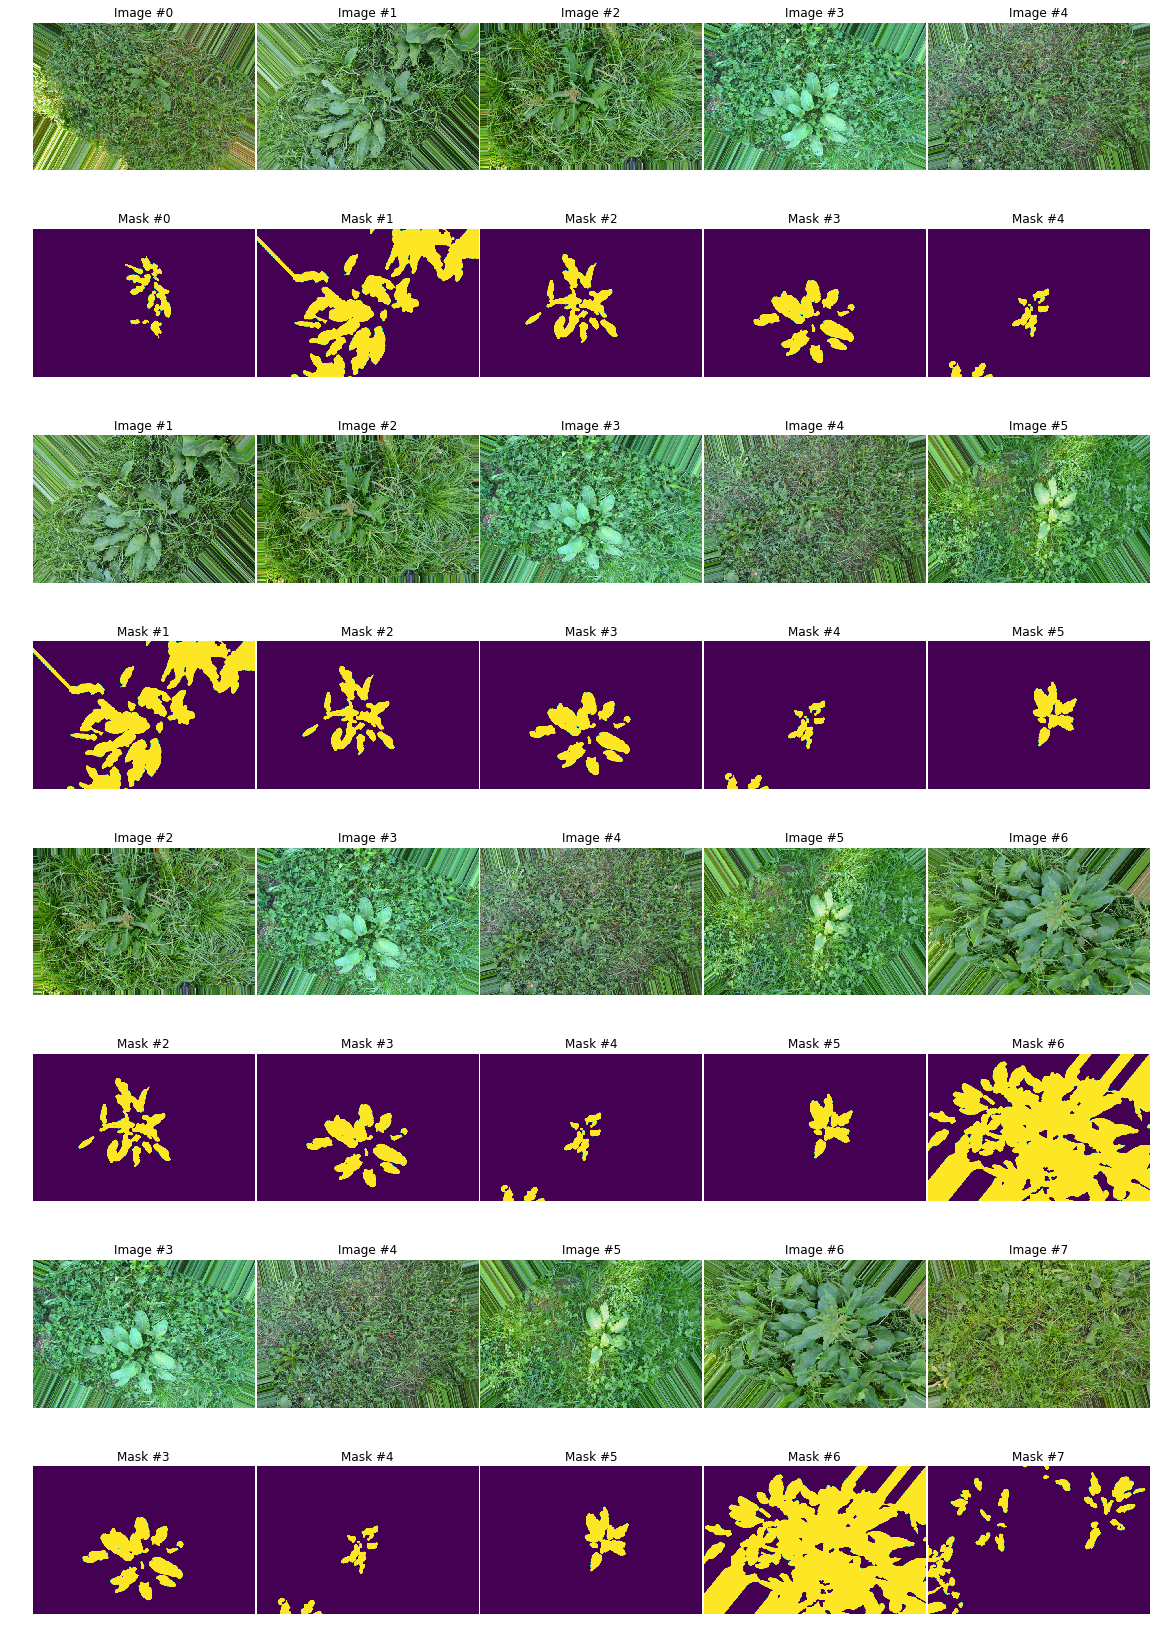

In [31]:
plt.figure(figsize=(20,30))
x,y = 5,4
for i in range(y):
    for j in range(x):
        plt.subplot(y*2,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2,x,(i*2+1)*x+j+1)
        plt.imshow(msks[pos,:,:,:].reshape(SHAPE))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

### 3.2 Define Train- Generator:

In [13]:
# Based on Keras Sequence Class

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode, batch_size=2, target_size=SHAPE, shuffle=True):
        'Initialization'
        self.mode = mode
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_list = None
        self.mask_list = None
        self.__set_directory()
        self.__init_info()
        self.on_epoch_end()
        
    def __set_directory(self):
        if self.mode == 'train':
            self.directory = DATA_BASE_PATH+'/01_train/'
        if self.mode == 'augmented':
            self.directory = DATA_BASE_PATH+'/02_augmented/'
        if self.mode == 'val':
            self.directory = DATA_BASE_PATH+'/03_val/'
        if self.mode == 'test':
            self.directory = DATA_BASE_PATH+'/04_test/'
        self.image_list = os.listdir(self.directory+'images')
        self.mask_list = os.listdir(self.directory+'masks')
        assert len(self.image_list) == len(self.mask_list)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        tmp_name_list = [self.image_list[k] for k in indexes]

        # Generate data
        imgs, masks = self.__data_generation(tmp_name_list)

        return imgs, masks

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, tmp_name_list):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        imgs = np.empty((self.batch_size, *self.target_size, 3))
        masks = np.empty((self.batch_size, *self.target_size, 1))

        # Generate data
        for i, name in enumerate(tmp_name_list):
            tmp_img = imread(self.directory+"images/"+name) 
            if self.mode == 'augmented':
                tmp_mask = imread(self.directory+"masks/"+name)[:,:,0]
            else:
                tmp_mask = imread(self.directory+"masks/"+name)
            #print(self.directory+"images/"+name)
            #print(tmp_mask.shape)
            tmp_img, tmp_mask = self.__adjust_data(tmp_img, tmp_mask)
            imgs[i,] = resize(tmp_img,(self.target_size[0],self.target_size[1])).reshape(*self.target_size,3)
            masks[i,] = resize(tmp_mask,(self.target_size[0],self.target_size[1])).reshape(*self.target_size,1)
        return imgs, masks
    
    def __adjust_data(self,img,mask):
        if img.max() > 1.0:
            img = img / 255
        if mask.max() > 1.0:
            mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return (img,mask)
    
    def __init_info(self):
        s = {"train" : "Training",
            "augmented" : "Training",
            "val" : "Validating",
            "test" : "Testing"}
        print(s[self.mode] + " on " + str(len(self.image_list)) + " Files")
    
    def generate_augmented_data():
        # Todo: Augment Data during training on CPU
        pass

### 3.3 Initialize Generators:

In [14]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'shuffle': True}

# Generators
training_generator = DataGenerator(mode='augmented',**params)
validation_generator = DataGenerator(mode='val',**params)

Training on 1770 Files
Validating on 127 Files


#### 3.4 Test Generator:

In [ ]:
i = iter(training_generator)

(512, 768, 3)
(512, 768, 1)
1.0


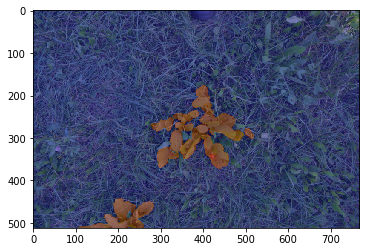

In [78]:
imgs, msks = next(i)
imshow(imgs[0])
imshow(msks[0].reshape(*SHAPE),cmap='jet',alpha=0.5)
print(imgs[0].shape)
print(msks[0].shape)
print(imgs[0].max())

### 3.5 Train:

In [11]:
## simple test
train_gen
BS = 1

H = model.fit_generator(
    train_gen,
    steps_per_epoch=8 // BS,
    epochs=1,
    verbose=1,
    use_multiprocessing=False,
    workers=1)

Epoch 1/1
8/8 [==============================] - 27s 3s/step - loss: 1.6040 - dice_coeff: 0.0927


In [18]:
BS = 4

H = model.fit_generator(
    training_generator,
    steps_per_epoch=1770 // BS,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BS,
    epochs=60,
    verbose=1,
    use_multiprocessing=False,
    max_queue_size=10,
    workers=1)

Epoch 1/60
442/442 [==============================] - 600s 1s/step - loss: 1.1945 - dice_coeff: 0.2256 - val_loss: 1.0556 - val_dice_coeff: 0.3150
Epoch 2/60
442/442 [==============================] - 584s 1s/step - loss: 0.9526 - dice_coeff: 0.3180 - val_loss: 0.8614 - val_dice_coeff: 0.3609
Epoch 3/60
442/442 [==============================] - 585s 1s/step - loss: 0.8201 - dice_coeff: 0.3863 - val_loss: 0.7422 - val_dice_coeff: 0.4228
Epoch 4/60
442/442 [==============================] - 584s 1s/step - loss: 0.7219 - dice_coeff: 0.4440 - val_loss: 0.6668 - val_dice_coeff: 0.4786
Epoch 5/60
442/442 [==============================] - 585s 1s/step - loss: 0.6389 - dice_coeff: 0.5001 - val_loss: 0.5491 - val_dice_coeff: 0.5710
Epoch 6/60
442/442 [==============================] - 585s 1s/step - loss: 0.5610 - dice_coeff: 0.5563 - val_loss: 0.5031 - val_dice_coeff: 0.6043
Epoch 7/60
442/442 [==============================] - 584s 1s/step - loss: 0.4953 - dice_coeff: 0.6083 - val_loss: 0.4

In [19]:
model.save('unet1024_60epochs.h5')

dict_keys(['val_loss', 'val_dice_coeff', 'loss', 'dice_coeff'])


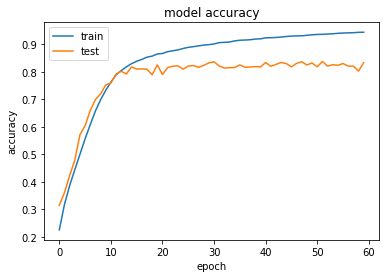

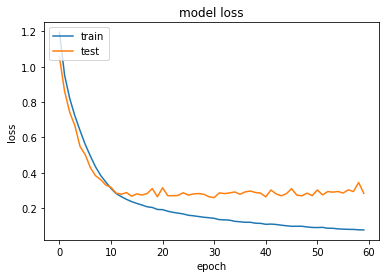

In [21]:
history = H
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coeff'])
plt.plot(history.history['val_dice_coeff'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3.6 Visualize Error Mask

In [84]:
vis_params = {'data_set':'val',
              'model':model}

predictions = Visualize(**vis_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [12]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = predictions.get_error_mask(index=row['Name'])
        error_sum += err
    return error_sum

In [13]:
summed_mask_error = predict_all_error(df.loc[df['Dataset'] == 'val'])

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

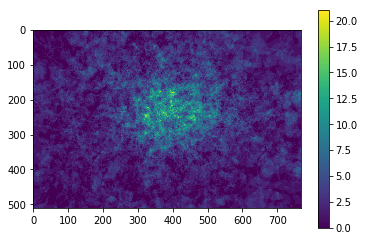

In [96]:
imshow(summed_mask_error)
plt.colorbar()

In [84]:
summed_mask_train = np.zeros(shape)
for i,row in df.iterrows():
    if row['Dataset'] == 'train':
        summed_mask_train += rle_decode(row['Mask'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

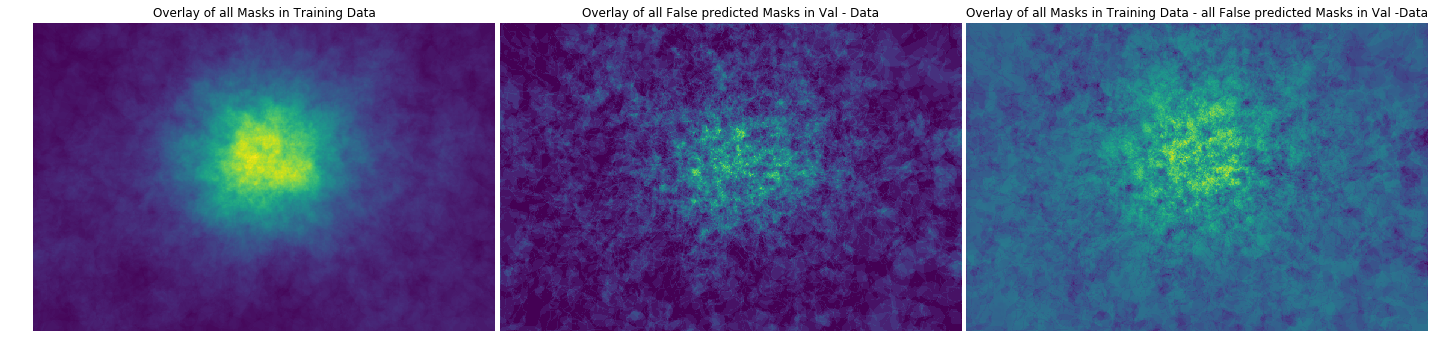

In [94]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.

<img src="../docs/notebook_images/False_negativ_positv.png">

In [24]:
df.loc[df['Dataset'] == "val"].sample(3)

Path Dataset  Name  \
478  ../data/03_val/     val  1478   
417  ../data/03_val/     val  1417   
475  ../data/03_val/     val  1475   

                                                  Mask  \
478  698 29 818 9 2234 31 2353 11 3770 31 3887 15 5...   
417  438508 3 440040 11 441574 15 443109 17 444644 ...   
475  107007 1 108539 9 110036 1 110073 13 111569 8 ...   

                                           Mask_Circle  \
478  536761 75 541348 117 545941 147 550537 171 555...   
417  1887196 75 1891783 117 1896376 147 1900972 171...   
475  76405 75 80992 117 85585 147 90181 171 94780 1...   

                                                 Roots  \
478  [[756.860730495, 225.099739471], [710.69078575...   
417  [[853.094844831, 518.794340161], [920.60268983...   
475  [[797.386664813, 489.076010127], [904.84234231...   

                                               Splines            Shape  
478  [[[691.707106864, 651.35220069], [726.09500191...  (1024, 1536, 3)  
417  [[[754.574568202, 359.710519678], [737.6823047...  (1024, 1536, 3)  
475  [[[608.502080278, 474.114327273], [696.4633244...  (1024, 1536, 3)

float64


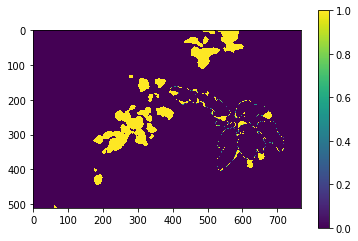

In [106]:
fe = predictions.get_full_error_mask(index='1357')
print(fe.dtype)
imshow(fe)
plt.colorbar()

float64


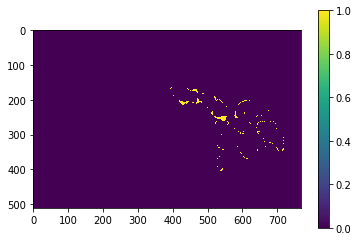

In [92]:
fp = predictions.get_false_positive_mask(index='1357')
print(fp.dtype)
imshow(fp)
plt.colorbar()

float64


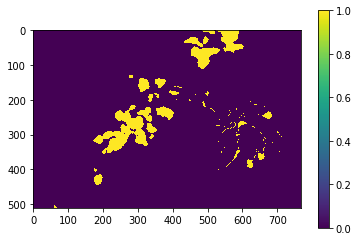

In [91]:
fn = predictions.get_false_negative_mask(index='1357')
print(fn.dtype)
imshow(fn)
plt.colorbar()

### Old Results:

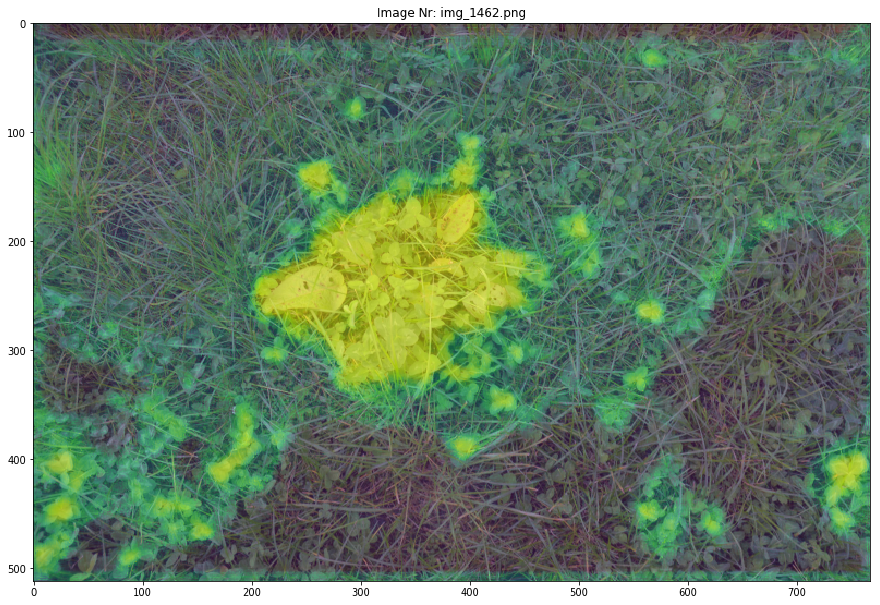

In [51]:
visualize.show(index='random',mode='image_prediction',save_dir=DATA_BASE_PATH+"/SaveDir/")

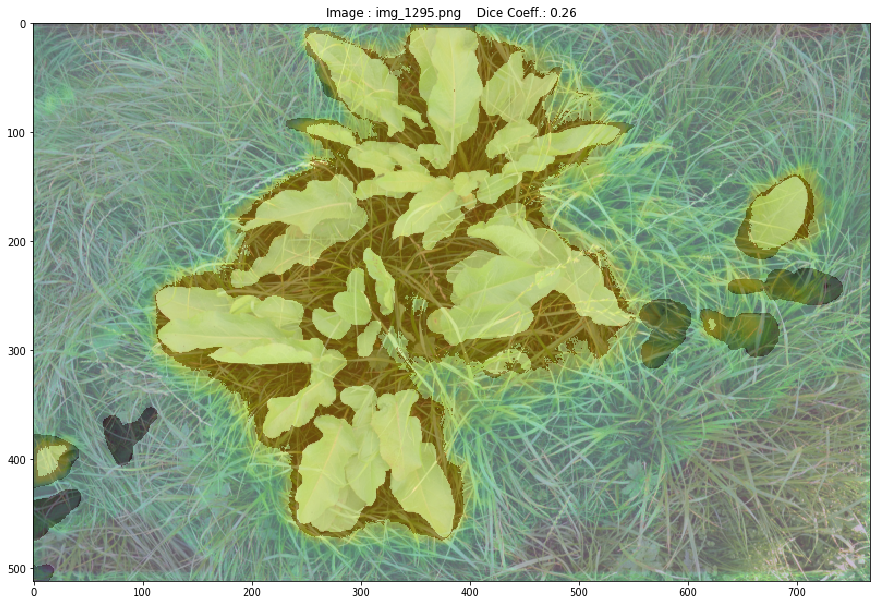

In [44]:
visualize.show(index='random',mode='image_prediction_error')